In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import signac
import gsd
import freud
from scipy.stats import uniform
from scipy.optimize import curve_fit
from scipy.special import erf
from joblib import Parallel, delayed

import pandas as pd

In [2]:
#Extracting information

poses = []
boxes = []
        
f = open("dump.lammpstrj")
text = f.readlines()

num_atoms = int(np.fromstring(text[3][:-1], sep=' ')[0])
num_frames = int(len(text) / (9 + num_atoms))


for i in range(0, num_frames, 1):
        it = 9 + (9+num_atoms)*i
        et = it + num_atoms
        box0 = np.fromstring(text[it-4][:13], sep=' ')*-20
        box1 = np.fromstring(text[it-3][:13], sep=' ')*-20

        boxes.append([box0, box1, box1])
        #print(box0)
        print(i,it, et)
        pos = []

        for j in range(it, et):
            pos.append(np.fromstring(text[j][:-1], sep=' '))

        poses.append(np.asarray(pos))                


        #break




f.close()





print('done')

0 9 10377
1 10386 20754
2 20763 31131
3 31140 41508
4 41517 51885
5 51894 62262
6 62271 72639
7 72648 83016
8 83025 93393
9 93402 103770
10 103779 114147
11 114156 124524
12 124533 134901
13 134910 145278
14 145287 155655
15 155664 166032
16 166041 176409
17 176418 186786
18 186795 197163
19 197172 207540
20 207549 217917
21 217926 228294
22 228303 238671
23 238680 249048
24 249057 259425
25 259434 269802
26 269811 280179
27 280188 290556
28 290565 300933
29 300942 311310
30 311319 321687
31 321696 332064
32 332073 342441
33 342450 352818
34 352827 363195
35 363204 373572
36 373581 383949
37 383958 394326
38 394335 404703
39 404712 415080
40 415089 425457
41 425466 435834
42 435843 446211
43 446220 456588
44 456597 466965
45 466974 477342
46 477351 487719
47 487728 498096
48 498105 508473
49 508482 518850
50 518859 529227
51 529236 539604
52 539613 549981
53 549990 560358
54 560367 570735
55 570744 581112
56 581121 591489
57 591498 601866
58 601875 612243
59 612252 622620
60 622629 632

437 4534758 4545126
438 4545135 4555503
439 4555512 4565880
440 4565889 4576257
441 4576266 4586634
442 4586643 4597011
443 4597020 4607388
444 4607397 4617765
445 4617774 4628142
446 4628151 4638519
447 4638528 4648896
448 4648905 4659273
449 4659282 4669650
450 4669659 4680027
451 4680036 4690404
452 4690413 4700781
453 4700790 4711158
454 4711167 4721535
455 4721544 4731912
456 4731921 4742289
457 4742298 4752666
458 4752675 4763043
459 4763052 4773420
460 4773429 4783797
461 4783806 4794174
462 4794183 4804551
463 4804560 4814928
464 4814937 4825305
465 4825314 4835682
466 4835691 4846059
467 4846068 4856436
468 4856445 4866813
469 4866822 4877190
470 4877199 4887567
471 4887576 4897944
472 4897953 4908321
473 4908330 4918698
474 4918707 4929075
475 4929084 4939452
476 4939461 4949829
477 4949838 4960206
478 4960215 4970583
479 4970592 4980960
480 4980969 4991337
481 4991346 5001714
done


In [3]:


# Computing fields ignoring the fact that they are Gaussian Charges

projE = []

for i in range(100, len(poses), 100): #Ignoring the first 100 frames, only analyzing every 100 frames


    fbox = freud.box.Box.from_box(boxes[i])


    pos = poses[i]
    Opos = pos[:,2:][pos[:,0] == 2]
    Hpos = pos[:,2:][pos[:,0] == 1]
    Epos = pos[:,2:][pos[:,0] == 3]
    
    # Getting O to H vector
    vHpos = np.reshape(Hpos, [int(len(Hpos)/2), 2, 3])
    vEpos = np.reshape(Epos, [int(len(Epos)/3), 3, 3])
    omat = np.copy(vHpos)        
    omat[:,0] = fbox.wrap(vHpos[:,0,:] - Opos)
    omat[:,1] = fbox.wrap(vHpos[:,1] - Opos)
    omat = np.reshape(omat, [len(Hpos), 3])


    fields = []

    Hdel_list = (np.arange(0, len(Hpos))/2).astype('int') # Need these to ignore intramolecular E-fields
    Odel_list = (np.arange(0, len(Opos))).astype('int')
    Edel_list = (np.arange(0, len(Epos))/3).astype('int')


    for j in range(0,len(Hpos)):

        Hpoint = Hpos[j]
        tHpos = Hpos[Hdel_list != int(j/2)]
        tOpos = Opos[Odel_list != int(j/2)]
        tEpos = Epos[Edel_list != int(j/2)]


        dpos = fbox.wrap(Hpoint - tHpos)
        dis = np.linalg.norm(dpos, axis=1)
        dpos = dpos[dis > 1e-2]
        dis = dis[dis > 1e-2]
        direct = (dpos.T / dis).T
        Hfields = (direct.T / dis**2).T

        dpos = fbox.wrap(Hpoint - tOpos)
        dis = np.linalg.norm(dpos, axis=1)
        dpos = dpos[dis > 1e-2]
        dis = dis[dis >1e-2]
        direct = (dpos.T / dis).T
        Ofields = (direct.T / dis**2).T

        dpos = fbox.wrap(Hpoint - tEpos)
        dis = np.linalg.norm(dpos, axis=1)
        dpos = dpos[dis > 1e-2]
        dis = dis[dis >1e-2]
        direct = (dpos.T / dis).T
        Efields = (direct.T / dis**2).T

        field = (1*np.sum(Hfields, axis=0)
                 + 1*np.sum(Ofields, axis=0)
                 + -1*np.sum(Efields, axis=0))


        fields.append(field)


    projE.append(np.sum(omat*fields, axis=1))
    
    print(i)


            
projE = np.array(projE)

100
200
300
400


Text(0.5, 0, 'Field Strength (V/A)')

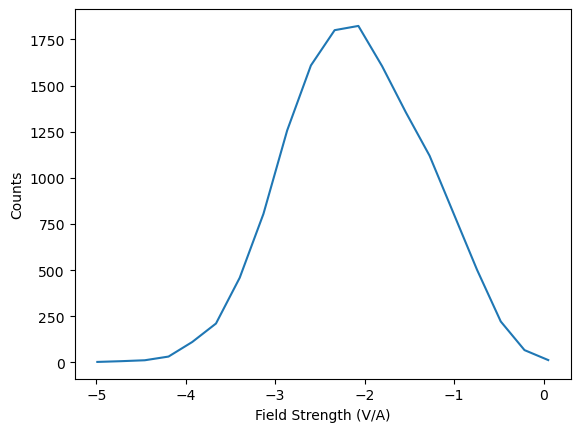

In [231]:


heights, bins = np.histogram(-14.4*projs, 20) # -14.4 is for conversion

binw = bins[1] - bins[0]
bin_centers = bins[:-1] + binw/2


plt.plot(bin_centers, heights)

plt.ylabel("Counts")
plt.xlabel("Field Strength (V/A)")

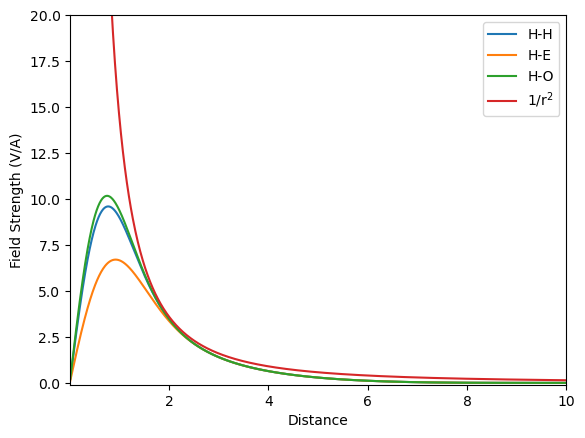

In [229]:
# Computing CGEM fields

from scipy.special import erf


Lambda = 2.06064

rO = 0.5414 
rH = 0.5749
rE = 0.784 

def CGEM_field(r1, r2, dis):
    
    
    alpha1 = Lambda / 2 / r1**2
    alpha2 = Lambda / 2 / r2**2
    
    
    innera = np.sqrt(alpha1*alpha2 / (alpha1 + alpha2))
    num1 = 2*innera*dis*np.exp(-innera**2*dis**2) / np.sqrt(np.pi)
    num2 = erf(innera*dis)
    denom = xx**2
    field = -(num1 - num2) / dis**2
    
    rcut = 10
    taper = 20*(dis/rcut)**7 - 70*(dis/rcut)**6 + 84*(dis/rcut)**5 - 35*(dis/rcut)**4 + 1
    
    field = taper*field
    field[dis > rcut] = 0
    return field


xx = np.linspace(0.01, 10, 1000)

yy = CGEM_field(rH, rH, xx)

plt.plot(xx, yy*14.4, label="H-H")

yy = CGEM_field(rH, rE, xx)

plt.plot(xx, yy*14.4, label="H-E")

yy = CGEM_field(rH, rO, xx)

plt.plot(xx, yy*14.4, label="H-O")


plt.plot(xx, 14.4/xx**2, label="1/r$^2$")

plt.ylim(-0.1, 20)
plt.xlim(0.01, 10)
plt.xlabel("Distance")
plt.ylabel("Field Strength (V/A)")
plt.legend()

In [233]:

# Computing fields using Gaussican cores


projE = []

for i in range(100, len(poses), 100):


    fbox = freud.box.Box.from_box(boxes[i])


    pos = poses[i]
    Opos = pos[:,2:][pos[:,0] == 2]
    Hpos = pos[:,2:][pos[:,0] == 1]
    Epos = pos[:,2:][pos[:,0] == 3]
    
    
    
    vHpos = np.reshape(Hpos, [int(len(Hpos)/2), 2, 3])
    vEpos = np.reshape(Epos, [int(len(Epos)/3), 3, 3])
    omat = np.copy(vHpos)        
    omat[:,0] = fbox.wrap(vHpos[:,0,:] - Opos)
    omat[:,1] = fbox.wrap(vHpos[:,1] - Opos)
    omat = np.reshape(omat, [len(Hpos), 3])


    fields = []



    Hdel_list = (np.arange(0, len(Hpos))/2).astype('int')
    Odel_list = (np.arange(0, len(Opos))).astype('int')
    Edel_list = (np.arange(0, len(Epos))/3).astype('int')


    for j in range(0,len(Hpos)):

        Hpoint = Hpos[j]
        tHpos = Hpos[Hdel_list != int(j/2)]
        tOpos = Opos[Odel_list != int(j/2)]
        tEpos = Epos[Edel_list != int(j/2)]




        dpos = fbox.wrap(Hpoint - tHpos)
        dis = np.linalg.norm(dpos, axis=1)
        dpos = dpos[dis > 1e-2]
        dis = dis[dis > 1e-2]
        direct = (dpos.T / dis).T
        Hfields = (direct.T * CGEM_field(rH, rH, dis)).T


        dpos = fbox.wrap(Hpoint - tOpos)
        dis = np.linalg.norm(dpos, axis=1)
        dpos = dpos[dis > 1e-2]
        dis = dis[dis > 1e-2]
        direct = (dpos.T / dis).T
        Ofields = (direct.T * CGEM_field(rH, rO, dis)).T

        dpos = fbox.wrap(Hpoint - tEpos)
        dis = np.linalg.norm(dpos, axis=1)
        dpos = dpos[dis > 1e-2]
        dis = dis[dis > 1e-2]
        direct = (dpos.T / dis).T
        Efields = (direct.T * CGEM_field(rH, rE, dis)).T

        
        field = (1*np.sum(Hfields, axis=0)
                 + 1*np.sum(Ofields, axis=0)
                 + -1*np.sum(Efields, axis=0))


        fields.append(field)
        #break
        #print(np.sum(Hfields, axis=0), 1*np.sum(Ofields, axis=0), -1*np.sum(Efields, axis=0))


    projE.append(np.sum(omat*fields, axis=1))
    
    print(i)


            
projE = np.array(projE)

100
200
300
400


Text(0.5, 0, 'Field Strength (V/A)')

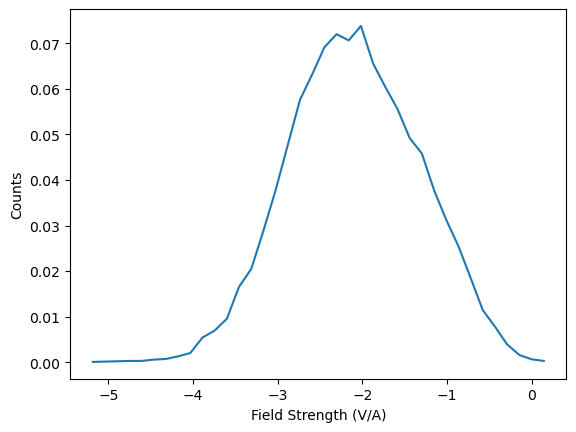

In [232]:


un, co = np.unique(np.round(projE, 2), return_counts=True)

plt.plot(un*-14.4, co/np.sum(co))

plt.ylabel("Counts")
plt.xlabel("Field Strength (V/A)")

[array([[-0.11817648, -0.14704418],
       [-0.11357788, -0.07023326],
       [-0.15294488, -0.03435561],
       ...,
       [-0.20508859, -0.09426089],
       [-0.17198949, -0.02154821],
       [-0.08409236, -0.13122699]], dtype=float32), array([[-0.0756577 , -0.130437  ],
       [-0.22865911, -0.03595458],
       [-0.11957894, -0.03086508],
       ...,
       [-0.13613248, -0.09592831],
       [-0.15084982, -0.08988983],
       [-0.12498599, -0.06627281]], dtype=float32), array([[-0.17070773, -0.13071516],
       [-0.17382658, -0.2057371 ],
       [-0.13768998, -0.15406695],
       ...,
       [-0.20068549, -0.14893548],
       [-0.06652506, -0.10967651],
       [-0.05756936, -0.09580622]], dtype=float32), array([[-0.1531995 , -0.08068633],
       [-0.13202882, -0.07826146],
       [-0.06707557, -0.0445941 ],
       ...,
       [-0.05032402, -0.14608277],
       [-0.15021935, -0.11321475],
       [-0.0415628 , -0.11519535]], dtype=float32), array([[-0.0793936 , -0.09746761],
       [

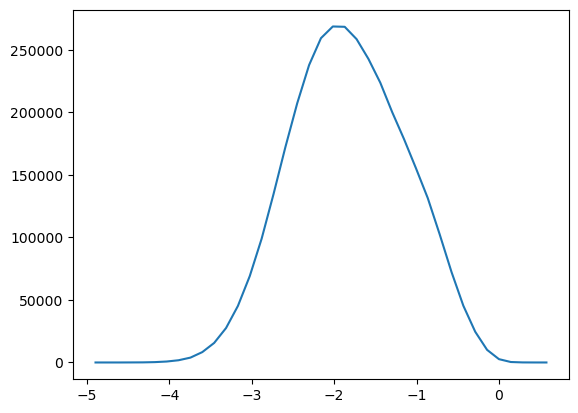

In [157]:
#np.save('projs1', projs[:-1])
#np.save('allHs1', tallHposes)
print(projs)
#print(projs[0][0][0])
#print(projs[0][0][1])
#print(np.max(np.concatenate(projs)))
un, co = np.unique(np.round(np.concatenate(projs[:]), 2), return_counts=True)
plt.plot(un*14.4, co)

print(len(projs[0][0]))
#print(proj2)

In [178]:
print(projs[0])

[[-0.11817648 -0.14704418]
 [-0.11357788 -0.07023326]
 [-0.15294488 -0.03435561]
 ...
 [-0.20508859 -0.09426089]
 [-0.17198949 -0.02154821]
 [-0.08409236 -0.13122699]]


In [191]:
print(len(allHpos[1]))
print(tallOposes[0])
print(tallHposes[0])

275
[[-22.941494  -25.138401  -13.825902 ]
 [ 19.879177   -2.8533611  11.644999 ]
 [-33.98606   -21.880503  -20.584702 ]
 ...
 [ 23.57166    10.611601    1.8800907]
 [ 31.251827  -24.075996    1.0437946]
 [ 20.884037   -7.8736534  27.1727   ]]
[[[-23.917385   -24.929502   -13.889199  ]
  [-22.670193   -25.174896   -12.8641    ]]

 [[ 19.692524    -1.985651    11.184305  ]
  [ 20.441257    -2.68647     12.455099  ]]

 [[-33.22287    -22.398201   -20.971401  ]
  [-34.75776    -22.495403   -20.422503  ]]

 ...

 [[ 23.095524    11.421999     1.5387516 ]
  [ 23.646923     9.935755     1.1469231 ]]

 [[ 30.778004   -23.211702     0.87501144]
  [ 32.225582   -23.966805     0.8440628 ]]

 [[ 21.130276    -7.726881   -27.603003  ]
  [ 21.058987    -7.0381336   26.6518    ]]]


In [102]:
print(projs[0])
print(projs[-1])

[array([[ 3.6086829e-04, -7.7091601e-05],
       [ 1.6514765e-04,  1.7764288e-04]], dtype=float32)]
[array([[ 3.6086829e-04, -7.7091601e-05],
       [ 1.6514765e-04,  1.7764288e-04]], dtype=float32)]


In [132]:
#print(np.concatenate(np.concatenate(projs[0], axis=0)))
print(len(projs))

#f = np.concatenate(np.concatenate(projs[0], axis=0))
print(tallHposes[0])
print(len(tallHposes[0][0]))
#print(len(projs[0][0]))
#print(len(tallHposes[0][0]))

1
[[[ -9.862946   22.636406    4.129076 ]
  [ -8.707554   22.422295    5.262905 ]]

 [[ -9.261147   16.452301   15.367294 ]
  [ -8.552753   17.918201   15.241299 ]]

 [[-21.549252   18.674503   -5.1904373]
  [-23.168644   18.7044     -5.3980484]]

 ...

 [[ 16.581757    2.6156693 -23.5966   ]
  [ 16.88295     1.7442818 -22.248802 ]]

 [[ 26.670258  -27.102596    6.6259346]
  [ 26.32486   -26.320896    8.017452 ]]

 [[ 23.445595  -10.117102  -21.713898 ]
  [ 22.616417   -9.438902  -20.481398 ]]]
2


32.80566723996666
3470040
[[-23.917385 -24.929502 -13.889199]
 [-22.670193 -25.174896 -12.8641  ]
 [ 19.692524  -1.985651  11.184305]
 ...
 [ 27.99128   27.609303 -14.420998]
 [ -8.350338  -8.127218 -17.9956  ]
 [ -9.549137  -9.236071 -17.9953  ]]
32.80566723996666
33717
32.80566723996666
5216


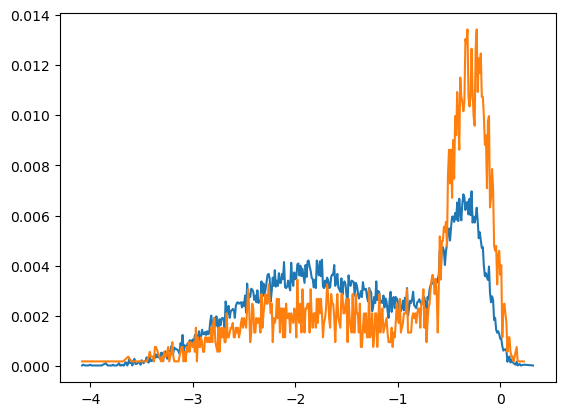

In [173]:


i = 1
print(fits[i][0])
xx = [fits[i][0], fits[i][0]+2]
proj = np.concatenate(projs)
Hposes = np.concatenate(np.concatenate(tallHposes[:]), axis=0)
print(len(Hposes))
print(Hposes)
for x in xx:
    print(fits[i][0])
    #Hposes = np.resize(tallHposes[i], []
    wh = np.where(np.abs(Hposes[:,0] > x))
    
    print(len(wh[0]))
    proposed = np.concatenate(proj)[wh]
    un, co = np.unique(np.round(proposed*14.4, 2), return_counts=True)
    plt.plot(un, co/np.sum(co))

In [174]:
print(projs)

[array([[-0.11817648, -0.14704418],
       [-0.11357788, -0.07023326],
       [-0.15294488, -0.03435561],
       ...,
       [-0.20508859, -0.09426089],
       [-0.17198949, -0.02154821],
       [-0.08409236, -0.13122699]], dtype=float32), array([[-0.0756577 , -0.130437  ],
       [-0.22865911, -0.03595458],
       [-0.11957894, -0.03086508],
       ...,
       [-0.13613248, -0.09592831],
       [-0.15084982, -0.08988983],
       [-0.12498599, -0.06627281]], dtype=float32), array([[-0.17070773, -0.13071516],
       [-0.17382658, -0.2057371 ],
       [-0.13768998, -0.15406695],
       ...,
       [-0.20068549, -0.14893548],
       [-0.06652506, -0.10967651],
       [-0.05756936, -0.09580622]], dtype=float32), array([[-0.1531995 , -0.08068633],
       [-0.13202882, -0.07826146],
       [-0.06707557, -0.0445941 ],
       ...,
       [-0.05032402, -0.14608277],
       [-0.15021935, -0.11321475],
       [-0.0415628 , -0.11519535]], dtype=float32), array([[-0.0793936 , -0.09746761],
       [

In [177]:
projs = np.asarray(projs)
tallHposes = np.asarray(tallHposes)


np.save("biprojs.npy", projs)
np.save("tallHposes.npy", tallHposes)



In [180]:
from scipy.spatial.distance import cdist
CHallHposes = []

CHprojs = []
for k in range(1,2):
    tHposes = []
    boxes = allbox[k]
    fbox = freud.box.Box.from_box(boxes[k])    
    Oposes = allOpos[k]
    Hposes = allHpos[k]
    poses = allpos[k]
    proj = []
    Hposes = np.reshape(Hposes, [len(Hposes), int(len(Hposes[0])/2), 2, 3])

    dismatrix = np.copy(Hposes)
    omatrix = np.copy(Hposes)
    print(len(Oposes[0]))
    print(len(Hposes[0]))
    for i in range(2):

        for j in range(len(dismatrix)):
            fbox = freud.box.Box.from_box(boxes[j])

            dismatrix[j,:,i,:] = fbox.wrap(Hposes[j,:,i,:] - Oposes[j])
            omatrix[j,:,i,:] = (dismatrix[j,:,i,:].T / 
                                np.linalg.norm(dismatrix[j,:,i,:], axis=1)).T

    
    for i in range(20, len(Hposes), 1000):
        sOpos = Oposes[i]
        sHpos = np.concatenate(Hposes[i])

        pos = poses[i]
        
        whO = np.where(pos[:,0] == 4)
        whH = np.where(pos[:,0] == 5)

        whC1 = np.where((pos[:,0] == 1)*(pos[:,1] == -0.222))
        whC2 = np.where((pos[:,0] == 1)*(pos[:,1] == -0.148))

        whH1 = np.where(pos[:,0] == 2)
        whH2 = np.where(pos[:,0] == 3)
        
        C1pos = pos[whC1][:,2:5]
        C2pos = pos[whC2][:,2:5]

        H1pos = pos[whH1][:,2:5]
        H2pos = pos[whH2][:,2:5]
        Opos = pos[whO][:,2:5]
        Hpos = pos[whH][:,2:5]

        
        fbox = freud.box.Box.from_box(boxes[i])
        fields = []
        omat = np.concatenate(omatrix[i])
        
        Hdel_list = (np.arange(0, len(Hpos))/2).astype('int')
        Odel_list = (np.arange(0, len(Opos))).astype('int')
#         aCfield = []
#         aOfield = []
#         aH1field = []
#         aH2field = []
#         aHfield = []


        for j in range(len(Hpos)):
            
            #print(np.where(Hdel_list == int(j/2)))
            pos = Hpos[j]
            tHpos = Hpos[Hdel_list != int(j/2)]
            tOpos = Opos[Odel_list != int(j/2)]
            #Opos = Oposes[j]
            dpos = fbox.wrap(tHpos - pos)
            dis = np.linalg.norm(dpos, axis=1)
            dpos = dpos[dis > 1e-2]
            dis = dis[dis > 1e-2]
            direct = (dpos.T / dis).T
            Hfields = (direct.T / dis**2).T
            
            dpos = fbox.wrap(tOpos - pos)
            dis = np.linalg.norm(dpos, axis=1)
            dpos = dpos[dis > 1e-2]
            dis = dis[dis >1e-2]
            direct = (dpos.T / dis).T
            Ofields = (direct.T / dis**2).T
            
            dpos = fbox.wrap(C1pos - pos)
            dis = np.linalg.norm(dpos, axis=1)
            dpos = dpos[dis > 1e-2]
            dis = dis[dis >1e-2]
            direct = (dpos.T / dis).T
            C1fields = (direct.T / dis**2).T
                        
            dpos = fbox.wrap(C2pos - pos)
            dis = np.linalg.norm(dpos, axis=1)
            dpos = dpos[dis > 1e-2]
            dis = dis[dis >1e-2]
            direct = (dpos.T / dis).T
            C2fields = (direct.T / dis**2).T
            
            dpos = fbox.wrap(H1pos - pos)
            dis = np.linalg.norm(dpos, axis=1)
            dpos = dpos[dis > 1e-2]
            dis = dis[dis >1e-2]
            direct = (dpos.T / dis).T
            H1fields = (direct.T / dis**2).T
            
            dpos = fbox.wrap(H2pos - pos)
            dis = np.linalg.norm(dpos, axis=1)
            dpos = dpos[dis > 1e-2]
            dis = dis[dis >1e-2]
            direct = (dpos.T / dis).T
            H2fields = (direct.T / dis**2).T
            
            
            field = (0.4238*np.sum(Hfields, axis=0) 
                     -0.8476*np.sum(Ofields, axis=0)
                     -0.222*np.sum(C1fields, axis=0)
                     -0.148*np.sum(C2fields, axis=0)                   
                     +0.074*np.sum(H1fields, axis=0)
                     +0.074*np.sum(H2fields, axis=0))
            
#             aCfields = np.sum(np.concatenate([C1fields, C2fields]), axis=0)
#             aOfields = np.sum(Ofields, axis=0)
#             aH1fields = np.sum(H1fields, axis=0)
#             aH2fields = np.sum(H2fields, axis=0)
#             aHfields = np.sum(Hfields, axis=0)

            
            fields.append(field)
            
            
#             aCfield.append(aCfields)
#             aOfield.append(aOfields)
#             aHfield.append(aHfields)
#             aH1field.append(aH1fields)
#             aH2field.append(aH2fields)

        
        tHposes.append(sHpos)
        
            #print(j)
            
        proj.append(np.sum(omat*fields, axis=1))
            
        #projs.append(proj)    
            
            
        print(i)
            
        #print(Hpos)
        #distance = cdist(Hpos, Hpos)
    print(k)
    CHprojs.append(proj)
    CHallHposes.append(np.asarray(tHposes))  

    #break #es
            
            
#np.save("cCHprojs", np.asarray(CHprojs))
#np.save("cCHtallHs", np.asarray(CHallHposes)) 
    
print('done')         

6804
6804
20
1
done


In [99]:
un, co = np.unique(np.round(CHprojs[:], 2), return_counts=True)
plt.plot(un*14.4, co)
#plt.xlim(-1, 1)
print(projs)
print(len(Hposes))
print(len(projs[0][0]))


NameError: name 'CHprojs' is not defined

10368
